In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import skimage as ski
from PIL import Image

In [2]:
wave_length = sp.constants.speed_of_sound / 40_000
omega = 2 * np.pi * wave_length # angular frequency
k = 2 * np.pi / wave_length  # wave number
phase_res = 8
amp_res = 8

In [3]:
# far field piston-source model: from https://jontallen.ece.illinois.edu/uploads/473.F18/Lectures/Chapter_7b.pdf
def p(r, theta, t):
    p_0 = 1.293 # density of air
    U_0 = 1000 # intensity, specifically, the speed at which the piston moves
    a = 0.005 # 5 mm: radius of the emitter
    # a = 1
    if np.sin(theta) == 0: # avoid a divide by 0
        return 1j * omega * p_0 * a**2 * U_0 / (2 * r) * np.e**(1j * (omega * t - k * r))
    else:
        return 1j * omega * p_0 * a**2 * U_0 / (2 * r) * np.e**(1j * (omega * t - k * r)) * 2 * sp.special.j1(k * a * np.sin(theta)) / ( k * a * np.sin(theta))

def p_r(vec_r, t):
    r = np.linalg.norm(vec_r)
    theta = np.arccos(vec_r[2]/r)
    return p(r, theta, t)

def p_sum(transducers, t_pressures, point):
    pressure = 0
    for x, y in np.ndindex(transducers.shape[:2]):
        vec_r = point - transducers[x, y]
        pressure += t_pressures[x, y] * p_r(vec_r, 0)
    return pressure 

In [4]:
V_p = 0.002**3 # (approximate) volume of particle, in this case 2mm^3
rho_p = 2000 # density of particle (TODO: use a more true value)
rho_0 = 1.293 # density of air
c_p = 4000 # speed of sound in particle (TODO: use a more true value)
c_0 = sp.constants.speed_of_sound # speed of sound in air

K_1 = 1 / 4 * V_p * (1 / (c_0**2 * rho_0) - 1 / (c_p**2 * rho_p))
K_2 = 3 / 4 * V_p * (rho_0 - rho_p) / (omega**2 * rho_0 * (rho_0 + 2 * rho_p))


def gorkov(transducers, t_pressures, point):
    h = 0.001
    p1 = p_sum(transducers, t_pressures, point)
    p2 = p_sum(transducers, t_pressures, point + np.array([0, 0, h]))
    dpdz = (p2 - p1) / h
    return K_1 * np.abs(p1)**2 - K_2 * np.abs(dpdz)**2

In [5]:
control_points = [np.array([0.025, 0.05, 0.1]), np.array([0.075, 0.05, 0.10])]
tx, ty = np.meshgrid(np.linspace(0.005, 0.095, 10), np.linspace(0.005, 0.095, 10))
transducers = np.dstack([tx, ty, np.zeros([10, 10])])
t_pressures = np.ones(transducers.shape[:2], dtype=complex)

In [6]:
gorkov(transducers, t_pressures, control_points[0])

0.004036637203610064

In [7]:
# partial derivatives wrt a singular transducer with complex pressure T * e^jphi
def dpdT_j(vec_r, phi):
    return np.e**(1j*phi) * p_r(vec_r, 0)

def dpdphi_j(vec_r, T, phi):
    return T * 1j * np.e**(1j*phi) * p_r(vec_r, 0)

def d2pdzdT_j(vec_r, phi):
    h = 0.0001
    return (dpdT_j(vec_r + np.array([0, 0, h]), phi) - dpdT_j(vec_r, phi)) / h

def d2pdzdphi_j(vec_r, T, phi):
    h = 0.0001
    return (dpdphi_j(vec_r + np.array([0, 0, h]), T, phi) - dpdphi_j(vec_r, T, phi)) / h

def grad_gorkov(transducers, t_pressures, point):
    h = 0.0001
    p1 = p_sum(transducers, t_pressures, point)
    p2 = p_sum(transducers, t_pressures, point + np.array([0, 0, h]))
    dpdz = (p2 - p1) / h

    # two gradients for T_j, phi_j
    grad = np.zeros(transducers.shape[:2] + (2,))
    for x, y in np.ndindex(transducers.shape[:2]):
        vec_r = point - transducers[x, y]
        T = np.abs(t_pressures[x, y])
        phi = np.angle(t_pressures[x, y])
        
        dp = dpdT_j(vec_r, phi)
        dpz = d2pdzdT_j(vec_r, phi)
        grad[x, y, 0] = 2 * K_1 * np.real(p1 * np.conjugate(dp)) - 2 * K_2 * np.real(dpdz * np.conjugate(dpz))
        
        dp = dpdphi_j(vec_r, T, phi)
        dpz = d2pdzdphi_j(vec_r, T, phi)
        grad[x, y, 1] = 2 * K_1 *  np.real(p1 * np.conjugate(dp)) - 2 * K_2 * np.real(dpdz * np.conjugate(dpz))

    return grad

In [8]:
t_pressures = np.ones(transducers.shape[:2], dtype=complex) 
cp_gorkov = np.zeros(len(control_points))
learning_rate = 100

max_gorkov = 0
last_gorkov = 0
# gradient descent
for i in range(500):
    grad = np.zeros(transducers.shape[:2] + (2,))
    for j, cp in enumerate(control_points):
        cp_gorkov[j] = gorkov(transducers, t_pressures, cp)
        grad += grad_gorkov(transducers, t_pressures, cp)

    for x, y in np.ndindex(t_pressures.shape):
        # T = np.abs(t_pressures[x, y]) - grad[x, y, 0] * learning_rate
        phi = np.angle(t_pressures[x, y]) + grad[x, y, 1] * learning_rate
        # t_pressures[x, y] = T * np.e**(1j*phi)
        t_pressures[x, y] = 1 * np.e**(1j*phi)

    cur_gorkov = np.sum(cp_gorkov)
    if cur_gorkov > max_gorkov:
        max_gorkov = cur_gorkov
    else:
        learning_rate = learning_rate / 2
        # pass

    print(cur_gorkov)
    if np.abs(cur_gorkov - last_gorkov) < 0.00001:
        break
    last_gorkov = cur_gorkov

0.008073274407220141
0.010858411113275575
0.0143746811885795
0.018673379672722805
0.023740970949610425
0.02949547252457353
0.035817589035722255
0.04261311239545616
0.049870306983649665
0.05765794837391787
0.06603547124585596
0.07491275722552623
0.083957750056845
0.09263829397229185
0.10039195121196301
0.10683491515798324
0.11189726004745752
0.11579944470391193
0.11889413649009002
0.12149609764481134
0.12379109738403793
0.12583167573571338
0.12758872548271738
0.1290193164775575
0.13011353090605943
0.1309039315232047
0.13144907359053926
0.13181238839840692
0.13204880770185434
0.1322002242479238
0.13229621165484087
0.1323566718170574
0.13239460595686914
0.13241835260046633
0.13243319963838548
0.13244247735049308


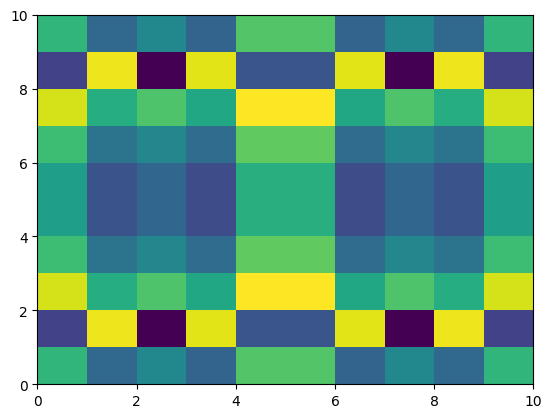

In [9]:
plt.pcolormesh(np.angle(t_pressures))

In [10]:
# produce a 3D mesh of resultant pressures
n = 80
size = 0.10
mesh = np.zeros([n, n, n*2], dtype=complex)
for x, y, z in np.ndindex(mesh.shape):
    if y == 0 and z == 0:
        print(x)
    mesh_point = np.array([x, y, z]) * size / n
    for i, j in np.ndindex(transducers.shape[:2]):
        vec_r = mesh_point - transducers[i, j]
        r = np.linalg.norm(vec_r)
        theta = np.arccos(vec_r[2]/r)
        if r != 0:
            mesh[x, y, z] += t_pressures[i, j] * p(r, theta, 0)

0
1
2
3
4


/tmp/ipykernel_3278/3382198125.py:12: RuntimeWarning: invalid value encountered in scalar divide
  theta = np.arccos(vec_r[2]/r)


5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79


Text(0.5, 0.92, "Pressure using Gor'kov algorithm")

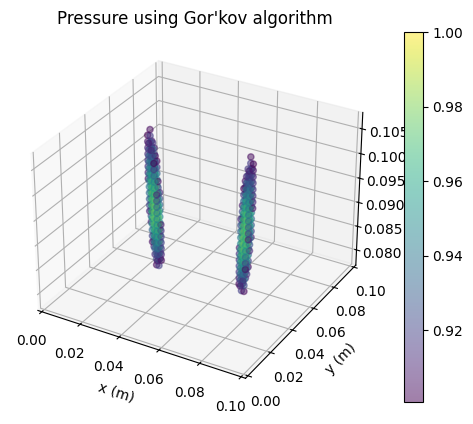

<Figure size 640x480 with 0 Axes>

In [11]:
ax = plt.figure().add_subplot(projection='3d')

meshn = mesh[:, :, 5:]
norm = np.abs(meshn)/np.max(np.abs(meshn))
angle = np.angle(meshn)
x, y, z = np.where(norm>0.9)

sc = ax.scatter(x*size/n, y*size/n, z*size/n, c=norm[x, y, z], alpha=0.5, cmap='viridis')
ax.set_xlim(0, 0.1)
ax.set_ylim(0, 0.1)
# sc = ax.contour(x*size/n, y*size/n, z*size/n, c=norm[x, y, z], alpha=0.5, cmap='viridis')
plt.figure().colorbar(sc)
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
ax.set_zlabel("z (m)")
ax.set_title("Pressure using Gor'kov algorithm")

Text(0.5, 1.0, "Pressure using Gor'kov algorithm, y = 0.075 m")

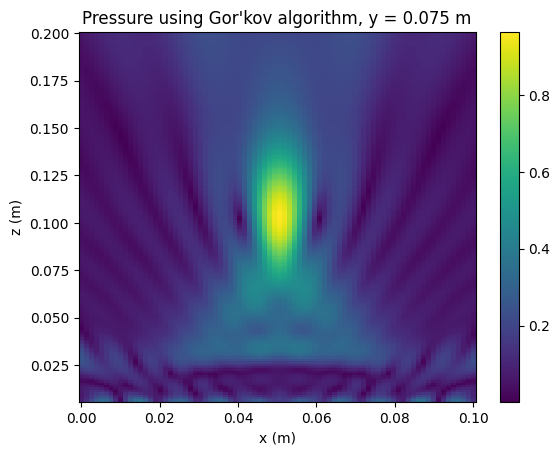

In [12]:
plt.pcolormesh(np.linspace(0, 0.1, n), np.linspace(0, 0.2, 2*n)[5:], norm[60, :, :].swapaxes(0, 1))
plt.colorbar()
plt.xlabel("x (m)")
plt.ylabel("z (m)")
plt.title(f"Pressure using Gor'kov algorithm, y = {0.1 / n * 60} m")

Text(0.5, 1.0, 'Pressure phase, y = 0.075 m')

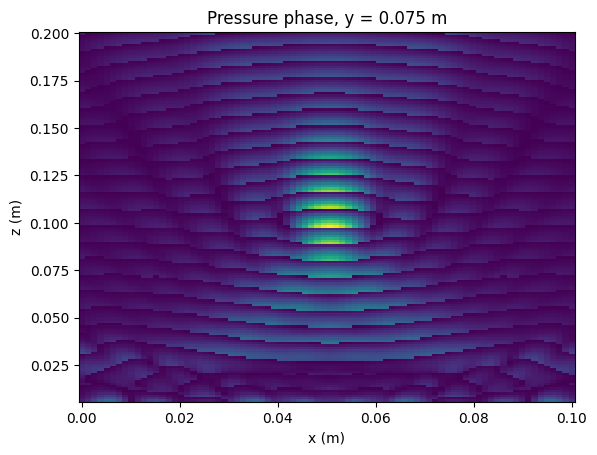

In [13]:
plt.pcolormesh(np.linspace(0, 0.1, n), np.linspace(0, 0.2, 2*n)[5:], ((angle[60, :, :] + np.pi) * norm[60, :, :]).swapaxes(0, 1))
plt.xlabel("x (m)")
plt.ylabel("z (m)")
plt.title(f"Pressure phase, y = {0.1 / n * 60} m")